# Knowledge Distillation with Hint Training: Experiment 2

Hint and Guided layer in beginning, middle and end.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
batch_size = 128

mean = torch.tensor([0.4914, 0.4822, 0.4465])
std = torch.tensor([0.2009, 0.2009, 0.2009])
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std = std)])
cifar_train_data = datasets.CIFAR100('./data', train=True, download=True, transform=transform)
cifar_test_data = datasets.CIFAR100('./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(cifar_train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(cifar_test_data, batch_size=batch_size)

100%|██████████| 169001437/169001437 [00:03<00:00, 43749897.20it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
for x, y in train_loader:
    print(x.shape)
    break

torch.Size([128, 3, 32, 32])


Network initializations

In [4]:
# Wide Shallow neural network class to be used as teacher:
# 3 different instantiations where the hint layer parameters are returned, either first, second, or third convolutional layer

class DeepNN(nn.Module):
    def __init__(self, num_classes=100):
        super(DeepNN, self).__init__()
        self.features1 = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.features2 = nn.Sequential(
            nn.Conv2d(128, 356, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.features3 = nn.Sequential(
            nn.Conv2d(356, 356, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(3204, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features1(x)
        conv_feature_map = x
        x = self.features2(x)
        x = self.features3(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x, conv_feature_map

In [5]:
#Training and testing loop normal
def test(model, test_dl):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    correct = 0
    num = 0
    with torch.no_grad():
        for (X, y) in test_dl:
            X, y = X.to(device), y.to(device)
            y_pred , _ = model(X)
            y_pred = torch.argmax(y_pred, dim=1)
            correct += torch.eq(y, y_pred).sum()
            num += X.shape[0]

    accuracy = correct / num
    return accuracy.item()

def train(model, lr, num_epochs, train_dl, test_dl):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    test_accuracy_list = []
    for epoch in range(1, num_epochs + 1):
        model.train()
        for X, y in train_dl:
            X, y = X.to(device), y.to(device)
            opt.zero_grad()
            y_pred, _ = model(X)
            loss = loss_fn(y_pred, y)
            loss.backward()
            opt.step()

        test_accuracy = test(model, test_dl)
        print(f"Test accuracy at epoch {epoch}: {test_accuracy:.4f}")
        test_accuracy_list.append(test_accuracy)
    return test_accuracy_list

In [6]:
#training teacher for 15 epochs
lr =  0.001
num_epochs = 15
teacher = DeepNN()

x = train(teacher, lr, num_epochs, train_loader, test_loader)
test_accuracy = test(teacher, test_loader)
print(f"Final teacher test accuracy on CIFAR-100: {test_accuracy:.4f}")

Test accuracy at epoch 1: 0.2287
Test accuracy at epoch 2: 0.3235
Test accuracy at epoch 3: 0.3659
Test accuracy at epoch 4: 0.3925
Test accuracy at epoch 5: 0.4160
Test accuracy at epoch 6: 0.4336
Test accuracy at epoch 7: 0.4471
Test accuracy at epoch 8: 0.4510
Test accuracy at epoch 9: 0.4566
Test accuracy at epoch 10: 0.4546
Test accuracy at epoch 11: 0.4566
Test accuracy at epoch 12: 0.4596
Test accuracy at epoch 13: 0.4515
Test accuracy at epoch 14: 0.4533
Test accuracy at epoch 15: 0.4578
Final teacher test accuracy on CIFAR-100: 0.4578


In [7]:
class LightNNRegressor4(nn.Module):
    def __init__(self, num_classes=100):
        super(LightNNRegressor4, self).__init__()
        self.features1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.features2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.features3= nn.Sequential(
            nn.Conv2d(32, 48, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(48, 48, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(48, 48, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(48, 48, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=2),
        )

        self.regressor = nn.Sequential(
            nn.Conv2d(16, 128, kernel_size=3, padding=1)
        )

        self.classifier = nn.Sequential(
            nn.Linear(432, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features1(x)
        regressor_output = self.regressor(x)
        x = self.features2(x)
        x = self.features3(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x, regressor_output


class LightNNRegressor3(nn.Module):
    def __init__(self, num_classes=100):
        super(LightNNRegressor3, self).__init__()
        self.features1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.features2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.features3= nn.Sequential(
            nn.Conv2d(32, 48, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(48, 48, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(48, 48, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=2),
        )

        self.regressor = nn.Sequential(
            nn.Conv2d(16, 128, kernel_size=3, padding=1)
        )

        self.classifier = nn.Sequential(
            nn.Linear(432, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features1(x)
        regressor_output = self.regressor(x)
        x = self.features2(x)
        x = self.features3(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x, regressor_output




class LightNNRegressor2(nn.Module):
    def __init__(self, num_classes=100):
        super(LightNNRegressor2, self).__init__()
        self.features1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.features2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.features3= nn.Sequential(
            nn.Conv2d(32, 48, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(48, 48, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=2),
        )

        self.regressor = nn.Sequential(
            nn.Conv2d(16, 128, kernel_size=3, padding=1)
        )

        self.classifier = nn.Sequential(
            nn.Linear(432, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features1(x)
        regressor_output = self.regressor(x)
        x = self.features2(x)
        x = self.features3(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x, regressor_output


class LightNNRegressor1(nn.Module):
    def __init__(self, num_classes=100):
        super(LightNNRegressor1, self).__init__()
        self.features1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.features2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.features3= nn.Sequential(
            nn.Conv2d(32, 48, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=2),
        )

        self.regressor = nn.Sequential(
            nn.Conv2d(16, 128, kernel_size=3, padding=1)
        )

        self.classifier = nn.Sequential(
            nn.Linear(432, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features1(x)
        regressor_output = self.regressor(x)
        x = self.features2(x)
        x = self.features3(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x, regressor_output



In [8]:
#Distillation loss
def test_d(model, test_dl):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    correct = 0
    num = 0
    with torch.no_grad():
        for (X, y) in test_dl:
            X, y = X.to(device), y.to(device)
            y_pred, _ = model(X)
            y_pred = torch.argmax(y_pred, dim=1)
            correct += torch.eq(y, y_pred).sum()
            num += X.shape[0]

    accuracy = correct / num
    return accuracy.item()

def train_d1(teacher, student, lr, num_epochs, temperature, alpha, train_dl, test_dl):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    teacher.to(device)
    student.to(device)
    opt = torch.optim.Adam(student.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    mse_loss = nn.MSELoss()

    test_accuracy_list = []
    for epoch in range(1, num_epochs + 1):
        student.train()
        running_loss = 0.0
        for X, y in train_dl:
            X, y = X.to(device), y.to(device)
            opt.zero_grad()
            student_logits, regressor_feature_map = student(X)
            with torch.no_grad():
                teacher_logits, teacher_feature_map = teacher(X)

            hidden_rep_loss = mse_loss(regressor_feature_map, teacher_feature_map)
            label_loss = loss_fn(student_logits, y)
            loss = label_loss
            loss = 0.25 * hidden_rep_loss + 0.75 * label_loss


            loss.backward()
            opt.step()

            running_loss += loss.item()

        #print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")

        test_accuracy = test(student, test_dl)
        print(f"Test accuracy at epoch {epoch}: {test_accuracy:.4f}")
        test_accuracy_list.append(test_accuracy)
    return test_accuracy_list


# Initialize a ModifiedLightNNRegressor
torch.manual_seed(42)
modified_nn_light_reg = LightNNRegressor1(num_classes=100).to(device)
modified_nn_light_reg2 = LightNNRegressor2(num_classes=100).to(device)
modified_nn_light_reg3 = LightNNRegressor3(num_classes=100).to(device)
modified_nn_light_reg4 = LightNNRegressor4(num_classes=100).to(device)

# We do not have to train the modified deep network from scratch of course, we just load its weights from the trained instance
modified_nn_deep_reg = DeepNN(num_classes=100).to(device)
modified_nn_deep_reg.load_state_dict(teacher.state_dict())
modified_nn_deep_reg2 = DeepNN(num_classes=100).to(device)
modified_nn_deep_reg2.load_state_dict(teacher.state_dict())
modified_nn_deep_reg3 = DeepNN(num_classes=100).to(device)
modified_nn_deep_reg3.load_state_dict(teacher.state_dict())
modified_nn_deep_reg4 = DeepNN(num_classes=100).to(device)
modified_nn_deep_reg4.load_state_dict(teacher.state_dict())

<All keys matched successfully>

In [9]:
for param in modified_nn_light_reg.classifier.parameters():
  param.requires_grad = False
for param in modified_nn_light_reg2.classifier.parameters():
  param.requires_grad = False
for param in modified_nn_light_reg3.classifier.parameters():
  param.requires_grad = False
for param in modified_nn_light_reg4.classifier.parameters():
  param.requires_grad = False

# Train and test once again
train_d1(teacher=modified_nn_deep_reg, student=modified_nn_light_reg, lr=0.001, num_epochs=10, temperature=0, alpha = 0, train_dl=train_loader, test_dl=test_loader)
train_d1(teacher=modified_nn_deep_reg2, student=modified_nn_light_reg2, lr=0.001, num_epochs=10, temperature=0, alpha = 0, train_dl=train_loader, test_dl=test_loader)
train_d1(teacher=modified_nn_deep_reg3, student=modified_nn_light_reg3, lr=0.001, num_epochs=10, temperature=0, alpha = 0, train_dl=train_loader, test_dl=test_loader)
train_d1(teacher=modified_nn_deep_reg4, student=modified_nn_light_reg4, lr=0.001, num_epochs=10, temperature=0, alpha = 0, train_dl=train_loader, test_dl=test_loader)

Test accuracy at epoch 1: 0.0514
Test accuracy at epoch 2: 0.0645
Test accuracy at epoch 3: 0.0759
Test accuracy at epoch 4: 0.0859
Test accuracy at epoch 5: 0.0880
Test accuracy at epoch 6: 0.0953
Test accuracy at epoch 7: 0.1010
Test accuracy at epoch 8: 0.1040
Test accuracy at epoch 9: 0.1115
Test accuracy at epoch 10: 0.1129
Test accuracy at epoch 1: 0.0372
Test accuracy at epoch 2: 0.0670
Test accuracy at epoch 3: 0.0898
Test accuracy at epoch 4: 0.1021
Test accuracy at epoch 5: 0.1170
Test accuracy at epoch 6: 0.1240
Test accuracy at epoch 7: 0.1320
Test accuracy at epoch 8: 0.1471
Test accuracy at epoch 9: 0.1493
Test accuracy at epoch 10: 0.1629
Test accuracy at epoch 1: 0.0277
Test accuracy at epoch 2: 0.0731
Test accuracy at epoch 3: 0.1008
Test accuracy at epoch 4: 0.1186
Test accuracy at epoch 5: 0.1274
Test accuracy at epoch 6: 0.1457
Test accuracy at epoch 7: 0.1623
Test accuracy at epoch 8: 0.1680
Test accuracy at epoch 9: 0.1749
Test accuracy at epoch 10: 0.1786
Test ac

[0.009999999776482582,
 0.041099999099969864,
 0.06949999928474426,
 0.09119999408721924,
 0.10729999840259552,
 0.12539999186992645,
 0.14019998908042908,
 0.14319999516010284,
 0.16179999709129333,
 0.1687999963760376]

In [10]:
#unfreeze parameters and train finally with knowledge distillation for stage 2

for param in modified_nn_light_reg.classifier.parameters():
  param.requires_grad = True
for param in modified_nn_light_reg2.classifier.parameters():
  param.requires_grad = True
for param in modified_nn_light_reg3.classifier.parameters():
  param.requires_grad = True
for param in modified_nn_light_reg4.classifier.parameters():
  param.requires_grad = True


def test_d(model, test_dl):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    correct = 0
    num = 0
    with torch.no_grad():
        for (X, y) in test_dl:
            X, y = X.to(device), y.to(device)
            y_pred, _ = model(X)
            y_pred = torch.argmax(y_pred, dim=1)
            correct += torch.eq(y, y_pred).sum()
            num += X.shape[0]

    accuracy = correct / num
    return accuracy.item()

def train_d(teacher, student, lr, num_epochs, temperature, alpha, train_dl, test_dl):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    teacher.to(device)
    student.to(device)
    opt = torch.optim.Adam(student.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    test_accuracy_list = []
    for epoch in range(1, num_epochs + 1):
        student.train()
        running_loss = 0.0
        for X, y in train_dl:
            X, y = X.to(device), y.to(device)
            opt.zero_grad()
            student_logits, _ = student(X)
            with torch.no_grad():
                teacher_logits, _ = teacher(X)

            student_probs = torch.softmax(student_logits / temperature, dim=1)


            soft_targets = nn.functional.softmax(teacher_logits / temperature, dim=-1)
            soft_prob = nn.functional.log_softmax(student_logits / temperature, dim=-1)
            soft_targets_loss = -torch.sum(soft_targets * soft_prob) / soft_prob.size()[0] * (temperature**2)
            label_loss = loss_fn(student_logits, y)
            loss = 0.25 * soft_targets_loss + 0.75* label_loss


            loss.backward()
            opt.step()

            running_loss += loss.item()

        #print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")

        test_accuracy = test(student, test_dl)
        print(f"Test accuracy at epoch {epoch}: {test_accuracy:.4f}")
        test_accuracy_list.append(test_accuracy)
    return test_accuracy_list

In [11]:
train_d(teacher=modified_nn_deep_reg, student=modified_nn_light_reg, lr=0.001, num_epochs=10, temperature=2, alpha = 0.75, train_dl=train_loader, test_dl=test_loader)
train_d(teacher=modified_nn_deep_reg2, student=modified_nn_light_reg2,  lr=0.001, num_epochs=10, temperature=2, alpha = 0.75, train_dl=train_loader, test_dl=test_loader)
train_d(teacher=modified_nn_deep_reg3, student=modified_nn_light_reg3,  lr=0.001, num_epochs=10, temperature=2, alpha = 0.75, train_dl=train_loader, test_dl=test_loader)
train_d(teacher=modified_nn_deep_reg4, student=modified_nn_light_reg4,  lr=0.001, num_epochs=10, temperature=2, alpha = 0.75, train_dl=train_loader, test_dl=test_loader)

Test accuracy at epoch 1: 0.2703
Test accuracy at epoch 2: 0.3143
Test accuracy at epoch 3: 0.3333
Test accuracy at epoch 4: 0.3508
Test accuracy at epoch 5: 0.3585
Test accuracy at epoch 6: 0.3667
Test accuracy at epoch 7: 0.3727
Test accuracy at epoch 8: 0.3822
Test accuracy at epoch 9: 0.3786
Test accuracy at epoch 10: 0.3791
Test accuracy at epoch 1: 0.2662
Test accuracy at epoch 2: 0.2988
Test accuracy at epoch 3: 0.3131
Test accuracy at epoch 4: 0.3312
Test accuracy at epoch 5: 0.3421
Test accuracy at epoch 6: 0.3560
Test accuracy at epoch 7: 0.3650
Test accuracy at epoch 8: 0.3686
Test accuracy at epoch 9: 0.3750
Test accuracy at epoch 10: 0.3784
Test accuracy at epoch 1: 0.2403
Test accuracy at epoch 2: 0.2686
Test accuracy at epoch 3: 0.2975
Test accuracy at epoch 4: 0.3135
Test accuracy at epoch 5: 0.3280
Test accuracy at epoch 6: 0.3443
Test accuracy at epoch 7: 0.3512
Test accuracy at epoch 8: 0.3541
Test accuracy at epoch 9: 0.3544
Test accuracy at epoch 10: 0.3602
Test ac

[0.21789999306201935,
 0.24149999022483826,
 0.2694000005722046,
 0.2902999818325043,
 0.3093999922275543,
 0.3127000033855438,
 0.33329999446868896,
 0.32829999923706055,
 0.34059998393058777,
 0.35109999775886536]

In [12]:
def test_multiple_outputs(model, test_loader, device):
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs, _ = model(inputs) # Disregard the second tensor of the tuple
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

In [13]:
print(f"Teacher Accuracy:")
test_accuracy_deep = test(modified_nn_deep_reg, test_loader)


print(f"{(100*test_accuracy_deep):.2f}%")
print(f"Final Student Accuracy (3 conv layers):")
test_accuracy_light_ce_and_mse_loss1 = test_multiple_outputs(modified_nn_light_reg, test_loader, device)
print(f"Final Student Accuracy (6 conv layers):")
test_accuracy_light_ce_and_mse_loss2 = test_multiple_outputs(modified_nn_light_reg2, test_loader, device)
print(f"Final Student Accuracy (9 conv layers):")
test_accuracy_light_ce_and_mse_loss3 = test_multiple_outputs(modified_nn_light_reg3, test_loader, device)
print(f"Final Student Accuracy (12 conv layers):")
test_accuracy_light_ce_and_mse_loss4 = test_multiple_outputs(modified_nn_light_reg4, test_loader, device)


Teacher Accuracy:
45.78%
Final Student Accuracy (3 conv layers):
Test Accuracy: 37.91%
Final Student Accuracy (6 conv layers):
Test Accuracy: 37.84%
Final Student Accuracy (9 conv layers):
Test Accuracy: 36.02%
Final Student Accuracy (12 conv layers):
Test Accuracy: 35.11%


In [14]:
nn_light = DeepNN(num_classes=100).to(device)
total_params_deep = "{:,}".format(sum(p.numel() for p in teacher.parameters()))
print(f"DeepNN parameters: {total_params_deep}")
total_params_light = "{:,}".format(sum(p.numel() for p in modified_nn_light_reg.parameters()))
print(f"LightNN1 parameters: {total_params_light}")
total_params_light = "{:,}".format(sum(p.numel() for p in modified_nn_light_reg2.parameters()))
print(f"LightNN2 parameters: {total_params_light}")
total_params_light = "{:,}".format(sum(p.numel() for p in modified_nn_light_reg3.parameters()))
print(f"LightNN3 parameters: {total_params_light}")
total_params_light = "{:,}".format(sum(p.numel() for p in modified_nn_light_reg4.parameters()))
print(f"LightNN4 parameters: {total_params_light}")

DeepNN parameters: 3,247,292
LightNN1 parameters: 105,844
LightNN2 parameters: 138,196
LightNN3 parameters: 170,548
LightNN4 parameters: 202,900


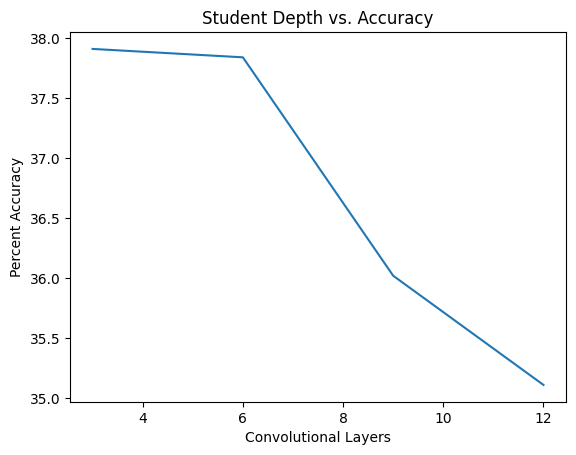

In [15]:
import matplotlib.pyplot as plt

# x axis values
x = [3,6,9,12]
# corresponding y axis values
y = [test_accuracy_light_ce_and_mse_loss1,test_accuracy_light_ce_and_mse_loss2,test_accuracy_light_ce_and_mse_loss3,test_accuracy_light_ce_and_mse_loss4]

# plotting the points
plt.plot(x, y)

# naming the x axis
plt.xlabel('Convolutional Layers')
# naming the y axis
plt.ylabel('Percent Accuracy')

# giving a title to my graph
plt.title('Student Depth vs. Accuracy')

# function to show the plot
plt.show()